# Tutorial: IBM PAIRS Geoscope RESTful API wrapper

Copyright 2019 Physical Analytics, IBM Research, IBM Corp. All Rights Reserved.

SPDX-License-Identifier: BSD-3-Clause

# Prelude: A general overview  of the workflow with `ibmpairs`

Given you are setup with IBM PAIRS credentials, the general workflow follows the recipe:
1. define your query using `JSON`, more precisely the equivalient of a Python dictionary `queryDef`
2. create a IBM PAIRS Python query object with the API wrapper: `query = paw.PAIRSQuery(queryDef, ...)`
3. submit your query to IBM PAIRS: `query.submit()`
4. wait until your result gets delivered by IBM PAIRS: `query.poll_till_finished()`
5. download your data locally: `query.download()`
6. check the data acknowledgement `query.print_data_acknowledgement()` which shows the text stored in `query.dataAcknowledgeText` 
7. get your data into memory: `query.create_layers()`
8. do your analysis of the data in `query.data` (or `query.vdf`, see below) with the help of corresponding meta data `query.metadata`
   Both structures are of type `dict` with the same key
   
For vector data, there is a helper structure `query.vdf` that can be populated from `query.data` to do some
useful manipulations.

**ATTENTION:** There is an exception for point queries to the rules above. Specifically, the point query data immediately get
loaded into `query.vdf`, and *not* stored in `query.data`. Of course, there is no corresponding `query.metadata` as well.

*TIP:* One can retrieve the IBM PAIRS polygons which are subsequently stored in `query.pdf` as a cache for reuse.
Moreover, it is possible to directly load previously queried data where the IBM PAIRS query ZIP files serve as a cache.

# Python module installs

In [15]:
!pip install --user git+https://github.com/ibm/ibmpairs

  Cloning https://github.com/ibm/ibmpairs (to develop) to /home/dsxuser/.tmp/pip-fqgmgimr-build
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmpairs==0.0.3)
Requirement not upgraded as not directly required: Pillow>=1.6 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmpairs==0.0.3)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmpairs==0.0.3)
Requirement not upgraded as not directly required: future in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmpairs==0.0.3)
Requirement not upgraded as not directly required: requests>=2.4 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmpairs==0.0.3)
Requirement not upgraded as not directly required: shapely in /home/dsxuser/.local/lib/python3.5/site-packages (from ibmpairs==0.0.3)
Requirement not upgraded as not directly required: ole

**ATTENTION**: In order to run the following cell, you might need to restart your Jupyter notebook kernel.

In [1]:
# IBM PAIRS open-source module
from ibmpairs import paw

# Setting the stage

## Get your IBM PAIRS credentials

1. Get your access to IBM PAIRS by visiting https://ibmpairs.mybluemix.net
2. send an e-mail to pairs@us.ibm.com with subject `enable backend access` and FROM set to your e-mail address used for signing up to IBM PAIRS

## Set up IBM PAIRS password file on your machine

In [3]:
%%writefile ibmpairspass.txt
pairs.res.ibm.com:<your e-mail>:<your password>

Writing ibmpairspass.txt


# Imports

In [2]:
# plotting libraries
from matplotlib import pyplot
import matplotlib
# numerical computation
import numpy
# handling tabular data
import pandas
# working with geometries
import shapely

# Settings

In [3]:
PAIRS_USER              = '<your e-mail>'
PAIRS_SERVER            = 'pairs.res.ibm.com'
BASE_URI                = '/'
PAIRS_PASSWORD          = paw.get_pairs_api_password(PAIRS_SERVER, PAIRS_USER, passFile='ibmpairspass.txt')
PAIRS_CREDENTIALS       = (PAIRS_USER, PAIRS_PASSWORD)

# How to do point queries to IBM PAIRS (temperature time series, PRISM data)

In [4]:
# define point query
pointQueryDef = {
    "layers" : [
        {"type": "raster", "id": "92"}
    ],
    "spatial": {
        "type": "point", 
        "coordinates": ["39", "-100.7", "40", "-90"]
    },
    "temporal": {
        "intervals": [
            {
                "start": "2018-01-01T00:00:00Z",
                "end": "2018-01-05T00:00:00Z"
            }
        ]
    }
}

In [5]:
# define PAIRS point query object
pointQuery = paw.PAIRSQuery(
    pointQueryDef,
    'https://'+PAIRS_SERVER,
    PAIRS_CREDENTIALS,
    baseURI=BASE_URI,
)

In [6]:
# submit PAIRS point query
pointQuery.submit()
pointQuery.poll_till_finished()
pointQuery.download()
pointQuery.create_layers()

INFO - 2019-05-15 05:08:31,679: "Point data successfully imported into self.vdf" [submit]
INFO - 2019-05-15 05:08:31,681: "Timestamp column 'timestamp' detected." [submit]
WARNING - 2019-05-15 05:08:31,750: "GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe." [set_lat_lon_columns]
INFO - 2019-05-15 05:08:31,751: "Geo-coordinate columns 'longitude' and 'latitude' detected." [submit]


In [7]:
# show result
pointQuery.vdf.head()

,dataset,latitude,layerId,layerName,longitude,timestamp,value,geometry
0,Prism Historical Data,39.0,92,Daily Maximum Temperature,-100.7,2018-01-01 12:00:00+00:00,264.970947265625,POINT (-100.7 39)
1,Prism Historical Data,40.0,92,Daily Maximum Temperature,-90.0,2018-01-01 12:00:00+00:00,257.10748291015625,POINT (-90 40)
2,Prism Historical Data,39.0,92,Daily Maximum Temperature,-100.7,2018-01-02 12:00:00+00:00,273.7857666015625,POINT (-100.7 39)
3,Prism Historical Data,40.0,92,Daily Maximum Temperature,-90.0,2018-01-02 12:00:00+00:00,265.7462463378906,POINT (-90 40)
4,Prism Historical Data,39.0,92,Daily Maximum Temperature,-100.7,2018-01-03 12:00:00+00:00,280.50518798828125,POINT (-100.7 39)


In [8]:
# format columns identified for temporal and spatial tags (user defined)
## note: required only, if not automatically detected (cf. output above)
pointQuery.set_timestamp_column('timestamp')
pointQuery.set_lat_lon_columns('latitude', 'longitude', 'geometry')
pointQuery.vdf.head()

WARNING - 2019-05-15 05:08:31,872: "GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe." [set_lat_lon_columns]


,dataset,latitude,layerId,layerName,longitude,timestamp,value,geometry
0,Prism Historical Data,39.0,92,Daily Maximum Temperature,-100.7,2018-01-01 12:00:00+00:00,264.970947265625,POINT (-100.7 39)
1,Prism Historical Data,40.0,92,Daily Maximum Temperature,-90.0,2018-01-01 12:00:00+00:00,257.10748291015625,POINT (-90 40)
2,Prism Historical Data,39.0,92,Daily Maximum Temperature,-100.7,2018-01-02 12:00:00+00:00,273.7857666015625,POINT (-100.7 39)
3,Prism Historical Data,40.0,92,Daily Maximum Temperature,-90.0,2018-01-02 12:00:00+00:00,265.7462463378906,POINT (-90 40)
4,Prism Historical Data,39.0,92,Daily Maximum Temperature,-100.7,2018-01-03 12:00:00+00:00,280.50518798828125,POINT (-100.7 39)


## Yet another point query

In [9]:
# define point query
pointQueryDef2 = {
    "layers" : [
        {"id": "P385C4765"}
    ],
    "spatial": {
        "type": "point", 
        "coordinates": ["39", "-100.7"]
    },
    "temporal": {
        "intervals": [
            {
                "start": "2018-01-01T00:00:00Z",
                "end": "2018-01-03T00:00:00Z"
            }
        ]
    }
}

In [10]:
# define PAIRS point query object
pointQuery2 = paw.PAIRSQuery(
    pointQueryDef2,
    'https://'+PAIRS_SERVER,
    PAIRS_CREDENTIALS,
    baseURI=BASE_URI,
)

In [11]:
# submit PAIRS point query
pointQuery2.submit()
pointQuery2.poll_till_finished()
pointQuery2.download()
pointQuery2.create_layers()

INFO - 2019-05-15 05:08:40,155: "Point data successfully imported into self.vdf" [submit]
INFO - 2019-05-15 05:08:40,157: "Timestamp column 'timestamp' detected." [submit]
WARNING - 2019-05-15 05:08:40,249: "No geo-coordinate columns '['longitude', 'latitude']' detected." [submit]


In [12]:
pointQuery2.vdf.head()

,dataset,layerId,layerName,property,region,timestamp,unit,value
0,Prism Historical Data,P385C4765,tmean,county:50897,50897,2018-01-01 12:00:00+00:00,,-13.4992
1,Prism Historical Data,P385C4765,tmean,county:50897,50897,2018-01-02 12:00:00+00:00,,-9.36853


In [13]:
# split the property string column
pointQuery2.split_property_string_column()
pointQuery2.vdf.head()

,dataset,layerId,layerName,property,region,timestamp,unit,value,county
0,Prism Historical Data,P385C4765,tmean,county:50897,50897,2018-01-01 12:00:00+00:00,,-13.4992,50897
1,Prism Historical Data,P385C4765,tmean,county:50897,50897,2018-01-02 12:00:00+00:00,,-9.36853,50897


# How to get raster data from IBM PAIRS (U.S. weather data, PRISM)

In [12]:
rasterQueryDef = {
    "layers" : [
        {"id" : 92}, # temperature
        {"id" : 91}, # precipitation
    ],
    "spatial" : {
        "type" :        "square",
        "coordinates" : [23, -125, 50, -67], 
    },
    "temporal" : {
        "intervals": [
            {
                "start": "2018-01-01T00:00:00Z",
                "end": "2018-01-03T00:00:00Z"
            }
        ]

    }
}

In [13]:
# create PAIRS query instance
rasterQuery = paw.PAIRSQuery(
    rasterQueryDef,
    pairsHost   = 'https://'+PAIRS_SERVER,
    auth        = PAIRS_CREDENTIALS,
    baseURI     = BASE_URI,
)
# submit and download modified query
rasterQuery.submit()
rasterQuery.poll_till_finished(printStatus=True)
rasterQuery.download()

INFO - 2019-05-03 23:14:05,340: "Alright, PAIRS query sucessfully submitted, the reference ID is: 1556899200_26045280" [submit]
INFO - 2019-05-03 23:14:05,808: "Query status is 'Queued' ..." [poll_till_finished]
INFO - 2019-05-03 23:14:16,327: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:14:27,454: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:14:37,747: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:14:48,246: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:14:58,504: "Query status is 'Writing' ..." [poll_till_finished]
INFO - 2019-05-03 23:15:09,813: "Query status is 'Succeeded' ..." [poll_till_finished]
INFO - 2019-05-03 23:15:11,208: "Here we go, PAIRS query result successfully downloaded as './downloads/1556899200_26045280_262e33051565f8d34441870b446ab97c.zip'." [download]
INFO - 2019-05-03 23:15:11,210: "Data acknowledgement successfully loaded, print with `self.print_dat

In [14]:
# show all PAIRS meta data loaded
key, meta = list(rasterQuery.metadata.items())[0]
print(
    """
    layer key: {}
    meta data: {}
    """.format(key, meta)
)


    layer key: Prism Historical Data-Daily Maximum Temperature-01_01_2018T12_00_00
    meta data: {'datalayerName': 'Daily Maximum Temperature', 'datalayerId': '92', 'layerType': 'raster', 'details': {'pixelDimensions': {'numberPixelsLongitude': 1792, 'numberPixelsLatitude': 864, 'pixelSizeDegreeLatitude': 0.032768, 'pixelSizeDegreeLongitude': 0.032768}, 'pixelType': 'fl', 'boundingBox': {'maxLongitude': -66.753792, 'maxLatitude': 50.509184, 'minLatitude': 22.197632, 'minLongitude': -125.474048}, 'spatialRef': 'EPSG:4326', 'pixelNoDataVal': -9999.0, 'rasterStatistics': {'pixelCount': 783848, 'pixelStandardDeviation': 11.230068, 'pixelMin': 249.066833, 'pixelMax': 299.789886, 'pixelMean': 269.9749}}, 'name': 'Prism Historical Data-Daily Maximum Temperature-01_01_2018T12:00:00', 'timestamp': 1514808000}
    


In [16]:
# check the data acknowledgement
rasterQuery.print_data_acknowledgement()

INFO - 2019-05-03 23:15:22,611: "Data acknowledgement loaded already - print with `self.print_data_acknowledgement()`" [read_data_acknowledgement]


The data acknowledgement for self.data is:
-Lansat 7 and Landsat 8 datasets are derived from U.S. Geological Survey (USGS)/NASA Landsat Program
The USGS home page is http://www.usgs.gov  
The NASA home page is http://www.nasa.gov  

-MODIS datasets are derived from USGS MODIS program datasets 

-NED dataset is derived from Data available from the USGS  
See USGS Visual Identity System Guidance http://www.usgs.gov/visual-id/   for further details

-NED dataset is distributed by the Land Processes Distributed Active Archive Center (LP DAAC)
It is located at USGS/EROS, Sioux Falls, SD. http://lpdaac.usgs.gov 

-Global forecast system (GFS), North America Mesoscale (NAM), Climate Forecast System (CFS) are derived products from NOAA datasets
The NOAA home page is http://www.noaa.gov/ 

-soil data is derived from SSURGO datasets distributed by USDA under Creative Commons License
The web page of USDA is http://www.usda.gov/ 

-ECMWF datasets are derived Type B and Type C products from data an

In [17]:
# load data into memory
rasterQuery.create_layers()

WARNING - 2019-05-03 23:15:27,509: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:15:27,626: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:15:27,742: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:15:27,844: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]



    The raster bounding box for 'Prism Historical Data-Daily Maximum Temperature-01_01_2018T12_00_00' is:
    [<lon min>, <lon max>, <lat min>, <lat max>]: [-125.474048, -66.753792, 22.197632, 50.509184]
    


<IPython.core.display.Javascript object>


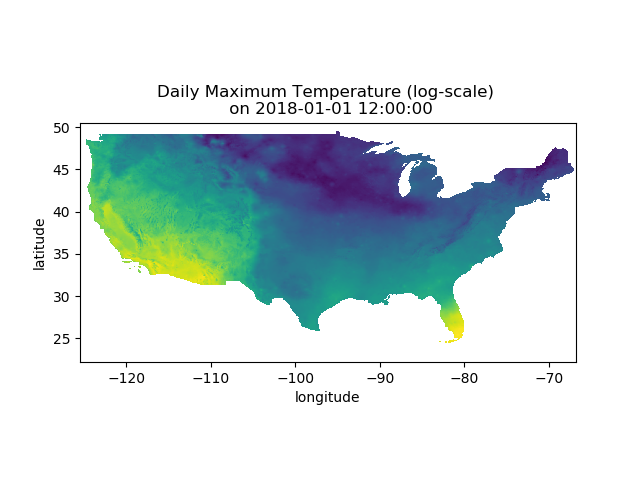

Text(0.5,1,'Daily Maximum Temperature (log-scale) \n on 2018-01-01 12:00:00')

In [18]:
# visualize a raster
%matplotlib notebook

# reference raster by name/key
layerNumber = 0
layerKey    = list(rasterQuery.metadata.keys())[layerNumber]

# print bounding box coordinate
# ATTENTION: does not necessarily need to 100% coincide with box queried!
print(
    """
    The raster bounding box for '{}' is:
    [<lon min>, <lon max>, <lat min>, <lat max>]: {}
    """.format(
        layerKey,
        [
            rasterQuery.metadata[layerKey]['details']['boundingBox']['minLongitude'],
            rasterQuery.metadata[layerKey]['details']['boundingBox']['maxLongitude'],
            rasterQuery.metadata[layerKey]['details']['boundingBox']['minLatitude'],
            rasterQuery.metadata[layerKey]['details']['boundingBox']['maxLatitude'],
        ]
    )
)

# plot raster
pyplot.imshow(
    numpy.log(1.+rasterQuery.data[layerKey]),
    extent=[
        rasterQuery.metadata[layerKey]['details']['boundingBox']['minLongitude'],
        rasterQuery.metadata[layerKey]['details']['boundingBox']['maxLongitude'],
        rasterQuery.metadata[layerKey]['details']['boundingBox']['minLatitude'],
        rasterQuery.metadata[layerKey]['details']['boundingBox']['maxLatitude'],
    ],
)

# label plot
pyplot.ylabel('latitude')
pyplot.xlabel('longitude')
pyplot.title(
    '{} (log-scale) \n on {}'.format(
        rasterQuery.metadata[layerKey]['datalayerName'],
        rasterQuery.metadata[layerKey]['timestamp'],
    )
)

# Want to reload your cached queries?

## Using an arbitrary IBM PAIRS query ZIP file

In [19]:
# get download directory and corresponding PAIRS query ZIP file
rasterQuery.downloadDir

'./downloads'

In [20]:
!ls -la downloads

total 4972
drwxr-x--- 2 dsxuser dsxuser    4096 May  3 23:15 .
drwxr-x--- 3 dsxuser dsxuser    4096 May  3 23:13 ..
-rw-r----- 1 dsxuser dsxuser 5082658 May  3 23:15 1556899200_26045280_262e33051565f8d34441870b446ab97c.zip


In [21]:
# reload data directly from query ZIP file
queryReload = paw.PAIRSQuery('downloads/1556899200_26045280_262e33051565f8d34441870b446ab97c.zip', None, None)
queryReload.list_layers()
queryReload.create_layers()

INFO - 2019-05-03 23:15:57,833: "Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`" [read_data_acknowledgement]
INFO - 2019-05-03 23:15:57,862: "PAIRS meta data loaded from 'output.info'." [list_layers]
WARNING - 2019-05-03 23:15:57,909: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:15:57,999: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:15:58,101: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:15:58,185: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]



    The raster bounding box for 'Prism Historical Data-Daily Maximum Temperature-01_02_2018T12_00_00' is:
    [<lon min>, <lon max>, <lat min>, <lat max>]: [-125.474048, -66.753792, 22.197632, 50.509184]
    


<IPython.core.display.Javascript object>


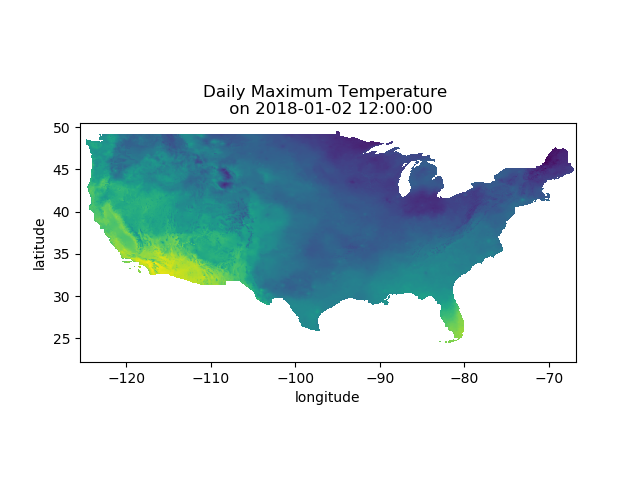

Text(0.5,1,'Daily Maximum Temperature \n on 2018-01-02 12:00:00')

In [22]:
# visualize a raster
%matplotlib notebook

# reference raster by name/key
layerNumber = 2
layerKey    = list(queryReload.metadata.keys())[layerNumber]

# print bounding box coordinate
# ATTENTION: does not necessarily need to 100% coincide with box queried!
print(
    """
    The raster bounding box for '{}' is:
    [<lon min>, <lon max>, <lat min>, <lat max>]: {}
    """.format(
        layerKey,
        [
            queryReload.metadata[layerKey]['details']['boundingBox']['minLongitude'],
            queryReload.metadata[layerKey]['details']['boundingBox']['maxLongitude'],
            queryReload.metadata[layerKey]['details']['boundingBox']['minLatitude'],
            queryReload.metadata[layerKey]['details']['boundingBox']['maxLatitude'],
        ]
    )
)

# plot raster
pyplot.imshow(
    rasterQuery.data[layerKey],
    extent=[
        queryReload.metadata[layerKey]['details']['boundingBox']['minLongitude'],
        queryReload.metadata[layerKey]['details']['boundingBox']['maxLongitude'],
        queryReload.metadata[layerKey]['details']['boundingBox']['minLatitude'],
        queryReload.metadata[layerKey]['details']['boundingBox']['maxLatitude'],
    ],
)

# label plot
pyplot.ylabel('latitude')
pyplot.xlabel('longitude')
pyplot.title(
    '{} \n on {}'.format(
        queryReload.metadata[layerKey]['datalayerName'],
        queryReload.metadata[layerKey]['timestamp'],
    )
)

## ... or using an existing query object 

*note*: The IBM PAIRS query JSON is used to match with the cache, taking the last of such queries downloaded if multiple identical queries have been run before.

In [23]:
# create PAIRS query instance
rasterQuery2 = paw.PAIRSQuery(
    rasterQueryDef,
    pairsHost           = 'https://'+PAIRS_SERVER,
    auth                = PAIRS_CREDENTIALS,
    baseURI             = BASE_URI,
    overwriteExisting   = False
)
# submit and download modified query
rasterQuery2.submit()
rasterQuery2.poll_till_finished(printStatus=True)
rasterQuery2.download()
rasterQuery2.create_layers()
rasterQuery2.data

WARNING - 2019-05-03 23:16:15,791: "Fake submit to PAIRS in order to use (latest) locally cached data." [submit]
INFO - 2019-05-03 23:16:15,862: "Alright, using cache of PAIRS query with ID: '1556899200_26045280'" [submit]
INFO - 2019-05-03 23:16:15,865: "Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`" [read_data_acknowledgement]
INFO - 2019-05-03 23:16:15,867: "PAIRS meta data loaded from 'output.info'." [list_layers]
WARNING - 2019-05-03 23:16:15,913: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:16:16,023: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:16:16,133: "GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data." [create_layer]
WARNING - 2019-05-03 23:16:16,218: "GDAL is not available for proper GeoT

{'Prism Historical Data-Daily Maximum Temperature-01_01_2018T12_00_00': array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),
 'Prism Historical Data-Daily Maximum Temperature-01_02_2018T12_00_00': array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),
 'Prism Historical Data-Daily Precipitation-01_01_2018T12_00_00': array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  na

**BOLD NOTE**: The boundary is most likely having no-data values, thus the `nan`s in the partially printed array.

Plot it to as before in order to see the data is there, or compute an aggregate value, e.g.:

In [24]:
[
    numpy.nanmean(data)
    for data in rasterQuery2.data.values()
]

[269.97489967602758,
 273.10403044134898,
 0.081944355900538016,
 0.23667956114857142]

# Raster query revised: US Aggregation by State

In [25]:
rasterAggQueryDef = {
    "layers" : [
        {"id" : 92}, # maximum temperature
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : [23, -125, 50, -67],
        "aggregation": {
            "aoi": [
                i for i in range(121, 175) # ConUS State PAIRS polygons
            ]
        }
    },
    "temporal" : {
        "intervals": [
            {
                "snapshot": "2018-01-01T00:00:00Z",
            }
        ]
    }
}

In [29]:
# create PAIRS query instance
rasterAggQuery = paw.PAIRSQuery(
    rasterAggQueryDef,
    pairsHost   = 'https://'+PAIRS_SERVER,
    auth        = PAIRS_CREDENTIALS,
    baseURI     = BASE_URI,
)
# submit and download modified query
rasterAggQuery.submit()
rasterAggQuery.poll_till_finished(printStatus=True)
rasterAggQuery.download()
rasterAggQuery.create_layers()

INFO - 2019-05-03 23:19:32,737: "Alright, PAIRS query sucessfully submitted, the reference ID is: 1556899200_26372679" [submit]
INFO - 2019-05-03 23:19:32,974: "Query status is 'Queued' ..." [poll_till_finished]
INFO - 2019-05-03 23:19:43,225: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:19:53,500: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:20:03,786: "Query status is 'Writing' ..." [poll_till_finished]
INFO - 2019-05-03 23:20:14,099: "Query status is 'Succeeded' ..." [poll_till_finished]
INFO - 2019-05-03 23:20:14,350: "Here we go, PAIRS query result successfully downloaded as './downloads/1556899200_26372679_0501165340ca06f0afa10c2d303580ae.zip'." [download]
INFO - 2019-05-03 23:20:14,352: "Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`" [read_data_acknowledgement]
INFO - 2019-05-03 23:20:14,354: "PAIRS meta data loaded from 'output.info'." [list_layers]


In [30]:
# show available meta data
rasterAggQuery.metadata

{'Prism Historical Data-Daily Maximum Temperature-12_31_2017T12_00_00': {'datalayerId': '92',
  'datalayerName': 'Daily Maximum Temperature',
  'layerType': 'raster',
  'name': 'Prism Historical Data-Daily Maximum Temperature-12_31_2017T12:00:00',
  'spatialAggregation': 'fullStat',
  'timestamp': datetime.datetime(2017, 12, 31, 12, 0)}}

In [31]:
# show the aggregated data
list(rasterAggQuery.data.values())[0].head()

,PAIRS polygon ID,count()[unit: km^2],min(),max(),mean(),2nd moment
0,145,131567.122892,268.384613,285.758301,275.318153,75814.502565
1,161,86861.619446,268.418091,283.117798,277.960308,77270.125854
2,154,128680.960434,264.156433,277.720184,271.932028,73952.715730
3,166,28041.671704,250.461426,259.859772,255.451225,65259.576250
4,168,185471.703491,264.195312,282.640503,273.779572,74969.583989


We can easily get the standard deviation from the 2nd moment employing
$$
    \langle \sigma\rangle^2 = \langle x^2\rangle - \langle x\rangle^2
$$
where $\langle x^2\rangle$ is the second moment, and $\langle x\rangle$ denotes the mean of $x$.

In [32]:
# assign the result to the PAIRS query vector data frame
rasterAggQuery.vdf = list(rasterAggQuery.data.values())[0]

# compute the standard deviation
rasterAggQuery.vdf['stdev()'] = numpy.sqrt(rasterAggQuery.vdf['2nd moment'] - rasterAggQuery.vdf['mean()']**2)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


In [33]:
# show the modified table
rasterAggQuery.vdf.head()

,PAIRS polygon ID,count()[unit: km^2],min(),max(),mean(),2nd moment,stdev()
0,145,131567.122892,268.384613,285.758301,275.318153,75814.502565,3.797003
1,161,86861.619446,268.418091,283.117798,277.960308,77270.125854,2.862346
2,154,128680.960434,264.156433,277.720184,271.932028,73952.715730,2.384978
3,166,28041.671704,250.461426,259.859772,255.451225,65259.576250,2.061005
4,168,185471.703491,264.195312,282.640503,273.779572,74969.583989,3.785484


Now we can collect the PAIRS polygon IDs in order to fetch the polygons themself like this:

In [34]:
# identify the PAIRS polygon ID column in the vector data frame
rasterAggQuery.set_geometry_id_column('PAIRS polygon ID')

In [35]:
# retrieve polygon information from PAIRS (which might take some time)
rasterAggQuery.get_vector_polygon_table(includeGeometry=True)

INFO - 2019-05-03 23:20:35,840: "Alright, start fetching 49 polygons from PAIRS, stay tuned ..." [get_vector_polygon_table]
INFO - 2019-05-03 23:20:47,685: "Let me get the polygon meta data information for you ..." [get_vector_polygon_table]
INFO - 2019-05-03 23:21:00,263: "Here you go, checkout your query object, property `pdf` for the result I assembled for you." [get_vector_polygon_table]


In [36]:
# show the table of retrieved geometries 
rasterAggQuery.pdf.head()

,polygon_id,polygon_name,geometry
0,145,USA - Mississippi,"(POLYGON ((-91.6453394956883 31.1847701878811,..."
1,161,USA - South Carolina,"(POLYGON ((-83.3155584009447 34.8538809168496,..."
2,154,USA - North Carolina,"(POLYGON ((-84.0799266720587 35.3105809766659,..."
3,166,USA - Vermont,(POLYGON ((-73.42208666705091 44.6493452691283...
4,168,USA - Washington,"(POLYGON ((-124.186843796768 46.886251294414, ..."


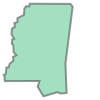

In [37]:
# plot a single US state shape (you can perform geometric operations with)
rasterAggQuery.pdf.geometry[0]

Alright, we can now join the two tables `PAIRSQuery.vdf` and `PAIRSQuery.pdf` for plotting:

In [38]:
joinedData = pandas.merge(
    rasterAggQuery.vdf,
    rasterAggQuery.pdf,
    how     = 'left',
    left_on = rasterAggQuery.vdf_geom_col_name,
    right_on='polygon_id',
)
joinedData.head()

,PAIRS polygon ID,count()[unit: km^2],min(),max(),mean(),2nd moment,stdev(),polygon_id,polygon_name,geometry
0,145,131567.122892,268.384613,285.758301,275.318153,75814.502565,3.797003,145,USA - Mississippi,"(POLYGON ((-91.6453394956883 31.1847701878811,..."
1,161,86861.619446,268.418091,283.117798,277.960308,77270.125854,2.862346,161,USA - South Carolina,"(POLYGON ((-83.3155584009447 34.8538809168496,..."
2,154,128680.960434,264.156433,277.720184,271.932028,73952.715730,2.384978,154,USA - North Carolina,"(POLYGON ((-84.0799266720587 35.3105809766659,..."
3,166,28041.671704,250.461426,259.859772,255.451225,65259.576250,2.061005,166,USA - Vermont,(POLYGON ((-73.42208666705091 44.6493452691283...
4,168,185471.703491,264.195312,282.640503,273.779572,74969.583989,3.785484,168,USA - Washington,"(POLYGON ((-124.186843796768 46.886251294414, ..."


<IPython.core.display.Javascript object>


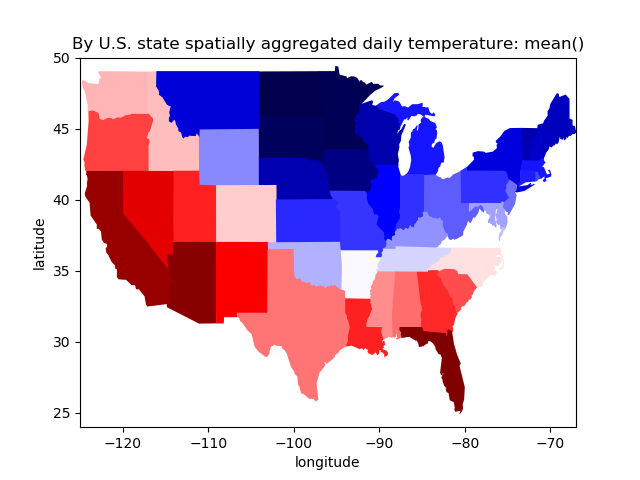

(24, 50)

In [39]:
%matplotlib notebook

# define aggregated quantity to plot
columnNameToPlot = 'mean()'

# generate patches of U.S. states for plotting
p = matplotlib.collections.PatchCollection(
    [
        matplotlib.patches.Polygon(
            numpy.array(
                [
                    [xy[0], xy[1]]
                    for xy in zip(
                        poly[0].exterior.coords.xy[0],
                        poly[0].exterior.coords.xy[1],
                    )
                ]
            ),
            True
        )
        for poly in joinedData.geometry
    ],
    cmap=matplotlib.cm.seismic,
)
p.set_array(joinedData[columnNameToPlot])

# label and plot data
pyplot.title('By U.S. state spatially aggregated daily temperature: {}'.format(columnNameToPlot))
ax = pyplot.gca()
ax.add_collection(p)
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
# set geospatial area to plot
pyplot.xlim(-125, -67)
pyplot.ylim(24,50)

# Finally: IBM PAIRS vector data

Note, that we already indirectly dealt with PAIRS vector in the section above where we pulled aggregated weather raster data by U.S. state.
Now let us directly query (county level) vector data out of PAIRS - by accident these are aggregated by the PAIRS team on the same PRISM raster
dataset we used before.

In [40]:
vectorQueryDef = {
    "layers": [
        {"id": "P385C4765"}, # county level aggregated daily mean temperature (as native layer in PAIRS)
    ],
    "spatial": {
        "type":  "poly",
        "aoi": 24, 
    },
    "temporal": {
        "intervals": [
            {
                "start": "2018-01-01T00:00:00Z",
                "end": "2018-01-01T23:59:59Z"
            }
        ]
    },
    "outputType": "csv"
}

In [41]:
# create PAIRS query instance
vectorQuery = paw.PAIRSQuery(
    vectorQueryDef,
    pairsHost   = 'https://'+PAIRS_SERVER,
    auth        = PAIRS_CREDENTIALS,
    baseURI     = BASE_URI,
)
# submit and download modified query
vectorQuery.submit()
vectorQuery.poll_till_finished(printStatus=True)
vectorQuery.download()
vectorQuery.create_layers()

INFO - 2019-05-03 23:22:10,627: "Alright, PAIRS query sucessfully submitted, the reference ID is: 1556899200_26530566" [submit]
INFO - 2019-05-03 23:22:10,886: "Query status is 'Queued' ..." [poll_till_finished]
INFO - 2019-05-03 23:22:21,171: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:22:31,475: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:22:41,774: "Query status is 'Running' ..." [poll_till_finished]
INFO - 2019-05-03 23:22:52,055: "Query status is 'Succeeded' ..." [poll_till_finished]
INFO - 2019-05-03 23:22:52,465: "Here we go, PAIRS query result successfully downloaded as './downloads/1556899200_26530566_df9aea23c91b746aac46e2d9fb2751ba.zip'." [download]
WARNING - 2019-05-03 23:22:52,466: "No PAIRS query ZIP file identified, or no acknowledgement in ZIP file found. Did you run `self.download()`, yet?" [read_data_acknowledgement]
WARNING - 2019-05-03 23:22:52,468: "No PAIRS meta data file 'output.info' found" [list_layers

In [42]:
# the meta data is minimalistic for now
vectorQuery.metadata

{'Vector_Data_Output': {'layerType': 'vector'}}

In [43]:
# associate vector data frame, and show the vector data
vectorQuery.vdf = vectorQuery.data[list(vectorQuery.metadata.keys())[0]]
vectorQuery.vdf.head()

,timestamp,DataSet,Name,Latitude,Longitude,Region,Unit,Value,PropertyString
0,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53141:Wyoming.Laramie,"""NA""",-8.55639,county:53141
1,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53140:Wyoming.Platte,"""NA""",-12.00760,county:53140
2,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53139:Wyoming.Goshen,"""NA""",-15.95040,county:53139
3,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53138:Wyoming.Converse,"""NA""",-13.87290,county:53138
4,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53137:Wyoming.Niobrara,"""NA""",-18.20700,county:53137


In [44]:
# split property string into individual columns
vectorQuery.split_property_string_column()
vectorQuery.vdf.head()

,timestamp,DataSet,Name,Latitude,Longitude,Region,Unit,Value,PropertyString,county
0,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53141:Wyoming.Laramie,"""NA""",-8.55639,county:53141,53141
1,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53140:Wyoming.Platte,"""NA""",-12.00760,county:53140,53140
2,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53139:Wyoming.Goshen,"""NA""",-15.95040,county:53139,53139
3,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53138:Wyoming.Converse,"""NA""",-13.87290,county:53138,53138
4,2018-01-01 12:00:00,Prism Historical Data,county_prism:tmean,NaN,NaN,53137:Wyoming.Niobrara,"""NA""",-18.20700,county:53137,53137


In [88]:
# define the column that contains geospatial information
vectorQuery.set_geometry_id_column('county')

In [89]:
# one more time retrieve the polygons from PAIRS, all US counties - that will take a couple of minutes ... relax and have a tea.
# note: the good thing is, you only need to do it once and then you can reuse!
vectorQuery.get_vector_polygon_table(includeGeometry=True)

INFO - 2019-04-13 02:11:57,138: "Alright, start fetching 2934 polygons from PAIRS, stay tuned ..." [get_vector_polygon_table]
INFO - 2019-04-13 02:24:06,854: "Let me get the polygon meta data information for you ..." [get_vector_polygon_table]
INFO - 2019-04-13 02:37:05,478: "Here you go, checkout your query object, property `pdf` for the result I assembled for you." [get_vector_polygon_table]


<IPython.core.display.Javascript object>


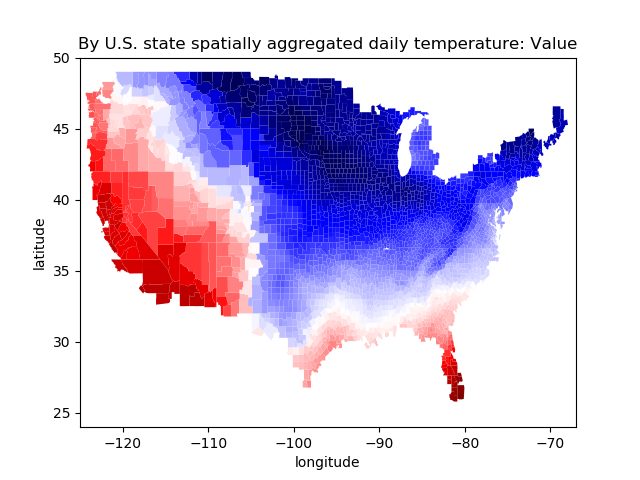

(24, 50)

In [90]:
# finally, let'splot the result - the same way we learned it already in the raster aggregation case!
%matplotlib notebook

# join dataframes
joinedData = pandas.merge(
    vectorQuery.vdf,
    vectorQuery.pdf,
    how     = 'left',
    left_on = vectorQuery.vdf_geom_col_name,
    right_on='polygon_id',
)

# define aggregated quantity to plot
columnNameToPlot = 'Value'

# generate patches of U.S. states for plotting
p = matplotlib.collections.PatchCollection(
    [
        matplotlib.patches.Polygon(
            numpy.array(
                [
                    [xy[0], xy[1]]
                    for xy in zip(
                        poly.exterior.coords.xy[0],
                        poly.exterior.coords.xy[1],
                    )
                ]
            ),
            True
        )
        for poly in joinedData.geometry
        if isinstance(poly, shapely.geometry.polygon.Polygon)
    ],
    cmap=matplotlib.cm.seismic,
)
p.set_array(joinedData[columnNameToPlot])
p.set_array(
    numpy.array(
    [
        val
        for val, poly in zip(joinedData[columnNameToPlot], joinedData.geometry)
        if isinstance(poly, shapely.geometry.polygon.Polygon)
    ]
    )
)

# label and plot data
pyplot.title('By U.S. state spatially aggregated daily temperature: {}'.format(columnNameToPlot))
ax = pyplot.gca()
ax.add_collection(p)
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
# set geospatial area to plot
pyplot.xlim(-125, -67)
pyplot.ylim(24, 50)